# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Number of 'user agents'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,theatergoing-mac,turing-chromebook,abroad-android,calcannea-cb,serotinal-mac,appropriate-android,dgmac,nervings-cb,tirasse-mac,venkata,...,MalcomWare-PC,traverses-mac,simon-macpro,essential-mac,turing-macbook,rarb-mac,daniel-chromebook,calcannea-mac,LAPTOP-1I501C4U,score
Roblox/217637 CFNetwork/897.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
MacAppStore/2.2 (Macintosh; OS,0,0,0,0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
com.apple.trustd/1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,44
ACC_2.00.3024_1A3C9AEC382A462E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
A/8.1.0/Google/Pixel#2/walleye,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Adobe GC 1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
dnf/1.1.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
amcuninstall/1.0 CFNetwork/897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Mac OS X/10.12.6 (16G29),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
Google Update/1.3.33.17;winhtt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Mozilla/5.0 (Windows NT 10.0; ',
       'Microsoft-WNS/10.0', 'Debian APT-HTTP/1.3 (1.2.26)',
       'MICROSOFT_DEVICE_METADATA_RETR', 'ClamAV/0.100.0 (OS: darwin17.5',
       'Microsoft-CryptoAPI/10.0', 'Spotify/8.4.61 Android/27 (Pix',
       'Mozilla/5.0 (Windows NT 6.1) A', 'Windows-Update-Agent/10.0.1001',
       'Safari/13605.2.8 CFNetwork/901', 'Microsoft BITS/7.8',
       'server-bag [Mac OS X,10.13.5,1', 'Software%20Update (unknown ver',
       'dnf/2.7.5', 'Mozilla/5.0 (Linux; Android 8.',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'server-bag [Mac OS X,10.

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['theatergoing-mac',
  array(['Mozilla/5.0 (Macintosh; Intel ', 'Microsoft-Delivery-Optimizatio',
         'Mozilla/5.0 (X11; Fedora; Linu', 'MICROSOFT_DEVICE_METADATA_RETR',
         'libdnf/0.11.1', 'trustd (unknown version) CFNet',
         'Debian APT-HTTP/1.3 (1.6~alpha', 'dnf/2.7.5',
         'Mac OS X/10.12.5 (16F73)', 'Mozilla/5.0 (Windows NT 10.0; ',
         'Software%20Update (unknown ver', 'Microsoft BITS/7.8',
         'Microsoft-CryptoAPI/10.0', 'Mozilla/5.0 (X11; Linux x86_64',
         'ocspd/1.0.3', 'Mac OS X/10.13.4 (17E202)',
         'Spotify/106900336 (9; 0; 2)', 'LookupViewService/221 CFNetwor',
         'Spotify/8.4.61 Android/27 (Pix', 'Safari/12605.2.8 CFNetwork/811',
         'ACC_2.00.3024_17F33DFE9BCBC137', 'Python-urllib/3.5',
         'Microsoft BITS/7.5', 'ACC_2.00.3024_16CE40735E8E8A0C',
         'Microsoft Windows Network Diag', 'Safari/13605.1.33.1.2 CFNetwor',
         'X-Lite/5.2.0.90533 Mozilla/5.0', 'Roblox/199282 CFNetwork/897.15',
         'Acro

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del..."
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (..."
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ..."
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (..."
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6..."
dgmac,"[trustd (unknown version) CFNet, CaptiveNetwor..."
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ..."
tirasse-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.28
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",0.21
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.21
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.20
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.19
misskitty-mac,"[Mozilla/5.0 (Macintosh; Intel , ClamAV/0.100....",0.18
steamverne-mac,"[Mozilla/5.0 (X11; Ubuntu; Linu, Mozilla/5.0 (...",0.18
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.17
traverses-mac,"[trustd (unknown version) CFNet, MacAppStore/2...",0.17


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,theatergoing-mac,turing-chromebook,abroad-android,calcannea-cb,serotinal-mac,appropriate-android,dgmac,nervings-cb,tirasse-mac,...,dramatic-mac,MalcomWare-PC,traverses-mac,simon-macpro,essential-mac,turing-macbook,rarb-mac,daniel-chromebook,calcannea-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",1.00,0.71,0.71,0.72,0.70,0.71,0.64,0.71,0.78,...,0.39,0.63,0.68,0.60,0.74,0.61,0.64,0.71,0.68,0.54
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.71,1.00,0.89,0.92,0.84,0.86,0.84,0.90,0.92,...,0.53,0.84,0.87,0.78,0.93,0.88,0.87,0.90,0.84,0.52
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",0.71,0.89,1.00,0.96,0.84,0.97,0.81,0.99,0.93,...,0.44,0.88,0.79,0.69,0.96,0.82,0.79,0.99,0.88,0.58
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.72,0.92,0.96,1.00,0.85,0.93,0.83,0.97,0.94,...,0.46,0.89,0.80,0.70,0.98,0.84,0.80,0.97,0.88,0.59
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.70,0.84,0.84,0.85,1.00,0.82,0.81,0.84,0.90,...,0.46,0.78,0.79,0.70,0.87,0.74,0.77,0.84,0.82,0.45
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6...",0.71,0.86,0.97,0.93,0.82,1.00,0.79,0.96,0.91,...,0.43,0.85,0.77,0.68,0.93,0.80,0.77,0.96,0.86,0.54
dgmac,"[trustd (unknown version) CFNet, CaptiveNetwor...",0.64,0.84,0.81,0.83,0.81,0.79,1.00,0.82,0.85,...,0.45,0.79,0.75,0.66,0.85,0.73,0.73,0.82,0.80,0.45
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",0.71,0.90,0.99,0.97,0.84,0.96,0.82,1.00,0.93,...,0.44,0.88,0.79,0.69,0.96,0.82,0.79,1.00,0.87,0.58
tirasse-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.78,0.92,0.93,0.94,0.90,0.91,0.85,0.93,1.00,...,0.51,0.86,0.85,0.76,0.96,0.83,0.86,0.93,0.88,0.54


In [15]:
## Don't need to calculate the log.

## Plot heatmap

In [16]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

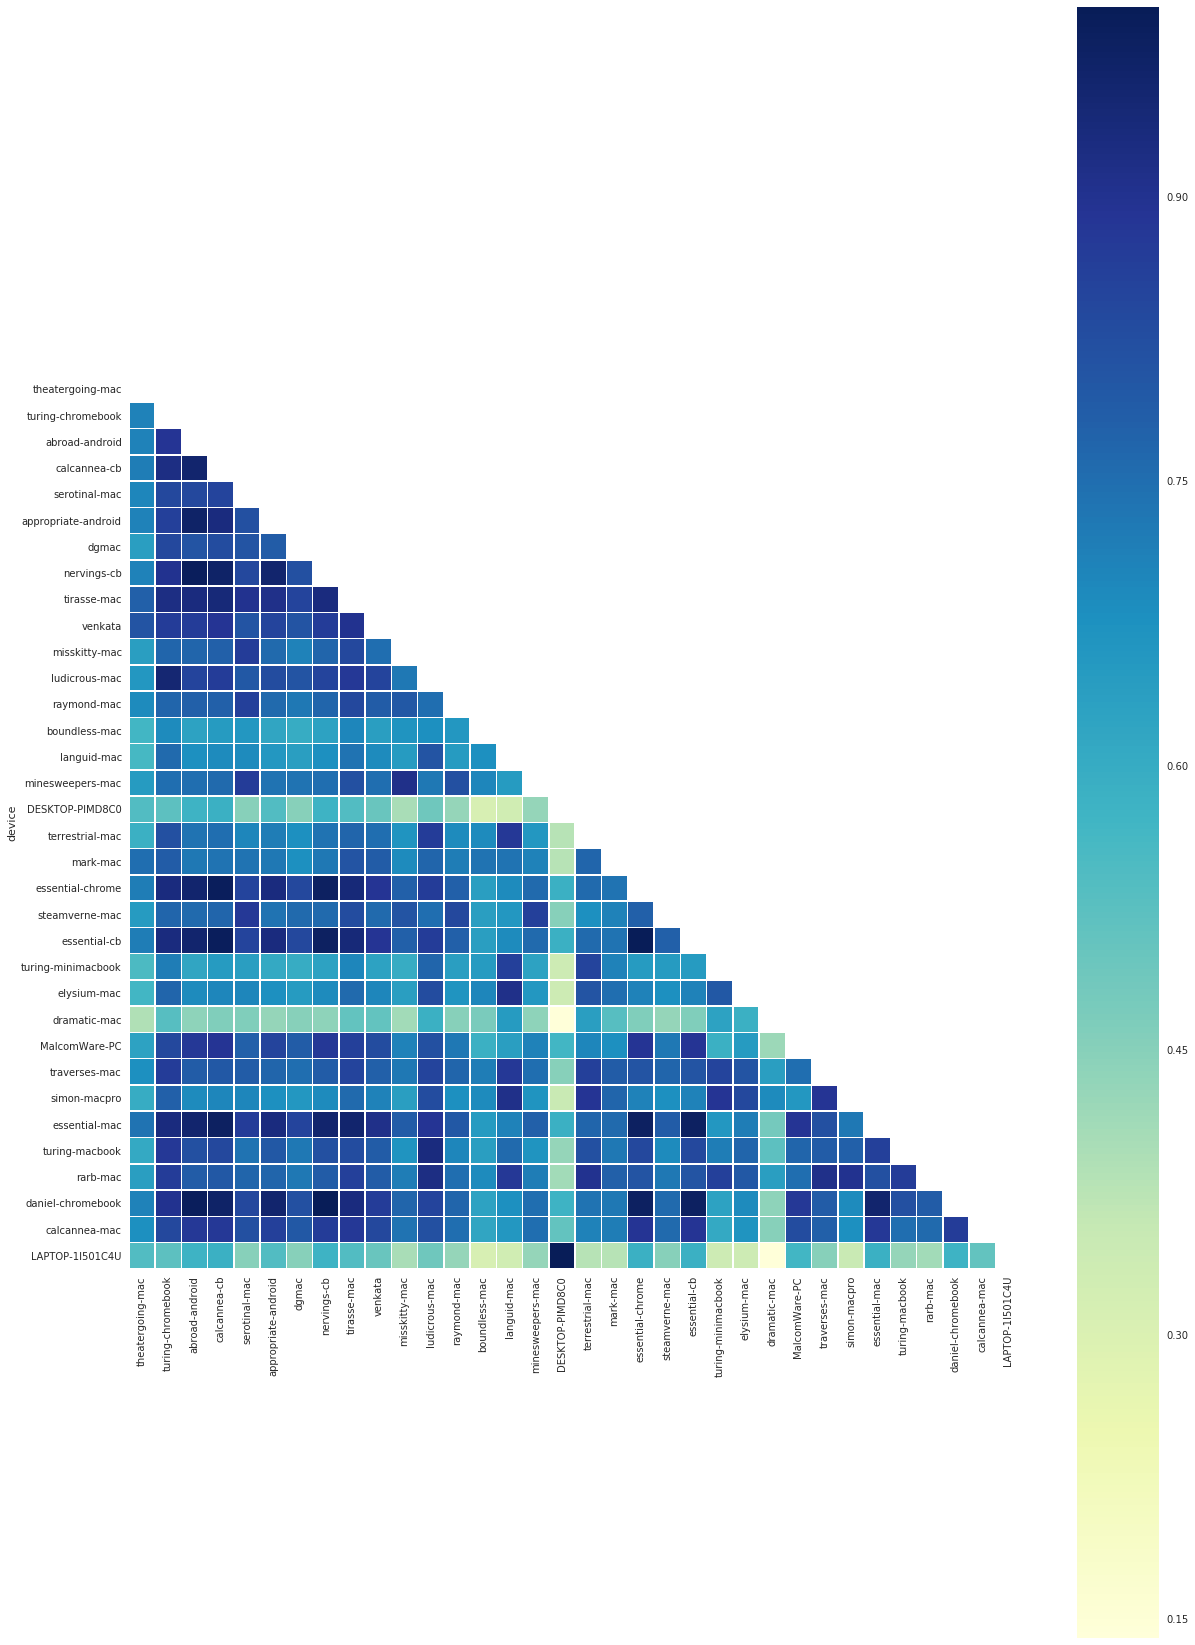

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Alternative rank correlation

Higher weights nearer the 'top' of the rank list

In [18]:
# Sum of geometric progression
def geosum(a1, r, n):
    return a1 * (1 - r ** n) / (1 - r)

In [19]:
geosum(1, 3, 4)

40.0

In [20]:
# Calculate Rho on 2 lists
def correlator(a, b):
    
    coeff = 1
    ratio = 0.9
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val * coeff * (ratio ** i)
        
        tot += val
                
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    x = 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )
    s = geosum(coeff, ratio, n)
    x /= s
    return x

In [21]:
print(correlator("abcde", "edcba"))
print(correlator("abcde", "abcde"))
print(correlator("abcde", "abced"))
print(correlator("abcdefghijklmnop", "abcdefghijklmnop"))
print(correlator("abcdefgh", "poiqqwe"))

-0.15889233474152042
0.24419428096993967
0.22728260604136646
0.12274487272346256
-0.5040367544906749


In [22]:
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: correlator(uas, x)).round(2)
df3

,useragents,theatergoing-mac,turing-chromebook,abroad-android,calcannea-cb,serotinal-mac,appropriate-android,dgmac,nervings-cb,tirasse-mac,...,dramatic-mac,MalcomWare-PC,traverses-mac,simon-macpro,essential-mac,turing-macbook,rarb-mac,daniel-chromebook,calcannea-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",0.10,0.10,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.09
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.09,0.10,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.08
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",0.09,0.09,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.09
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.09,0.10,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.09
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.09,0.10,0.10,0.1,0.10,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.08
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6...",0.09,0.09,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.08
dgmac,"[trustd (unknown version) CFNet, CaptiveNetwor...",0.09,0.10,0.10,0.1,0.09,0.10,0.10,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.08
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",0.09,0.09,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.09
tirasse-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.09,0.10,0.10,0.1,0.09,0.10,0.09,0.10,0.10,...,0.09,0.09,0.09,0.09,0.1,0.09,0.09,0.10,0.09,0.08


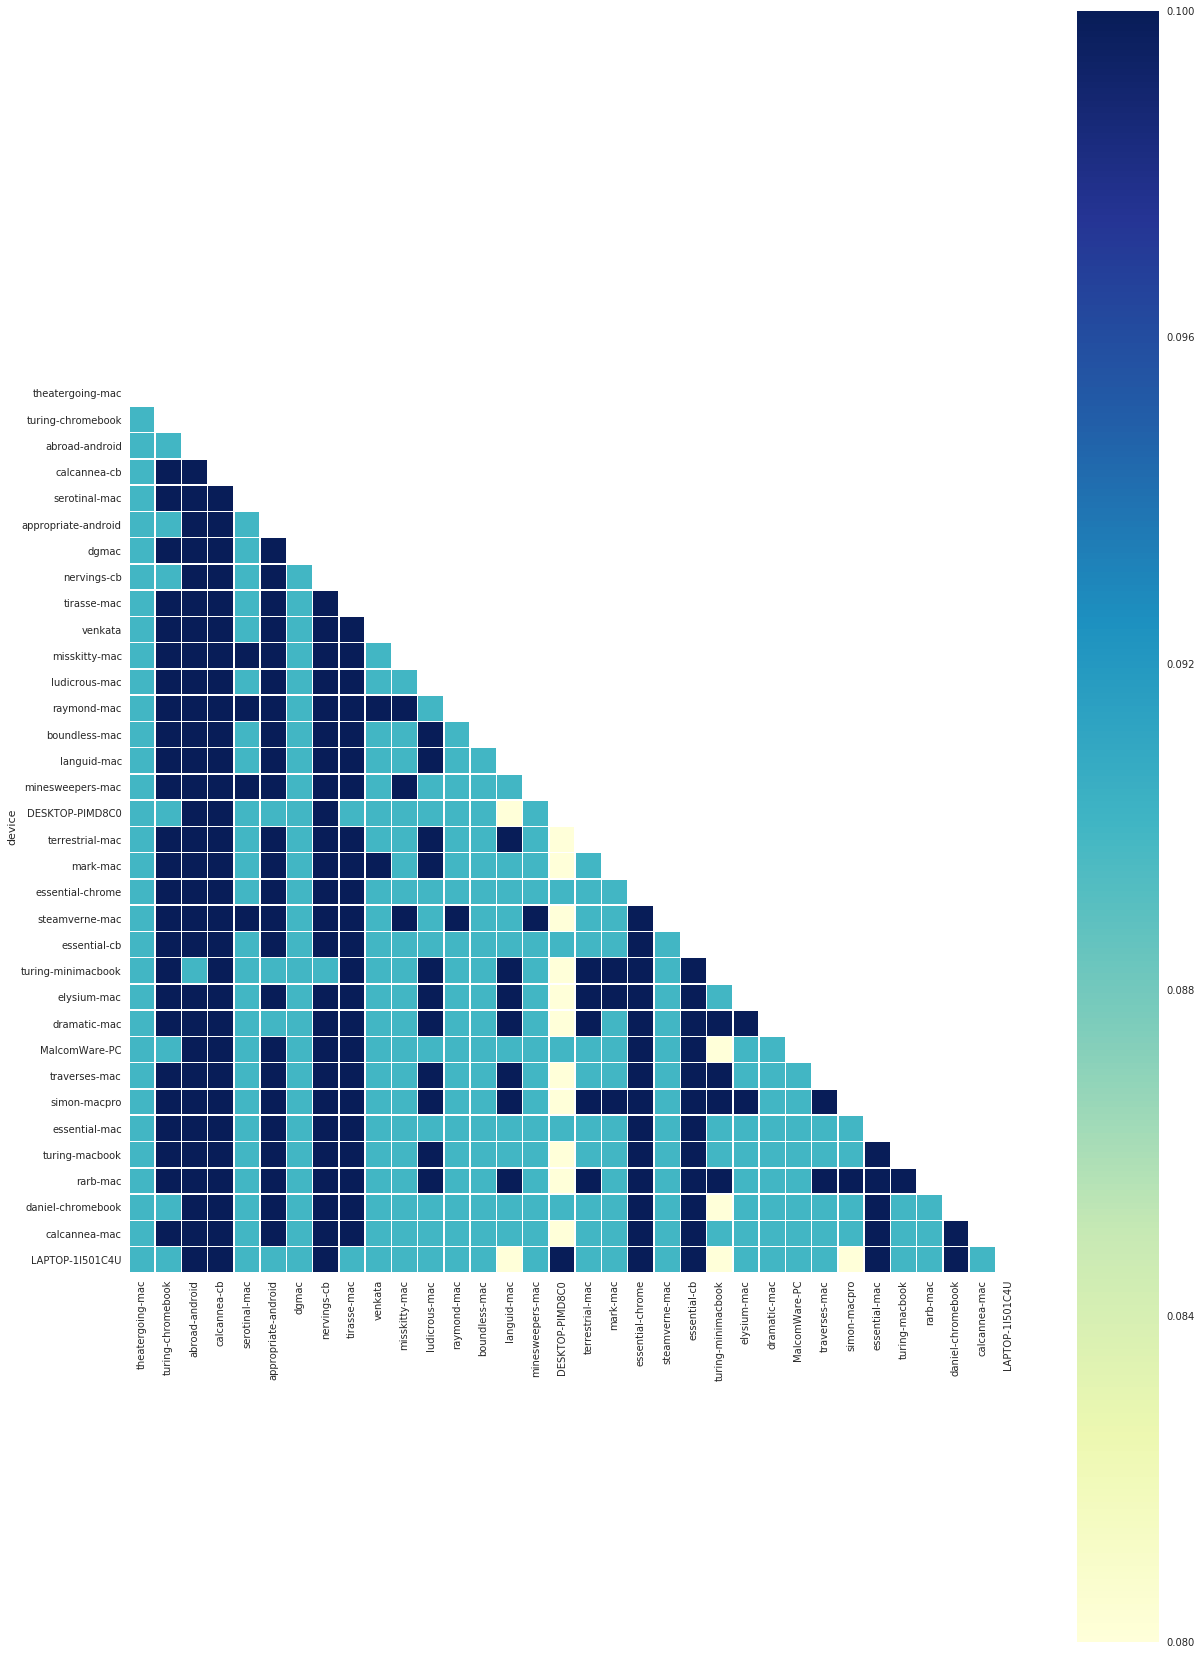

In [23]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [24]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [25]:
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: correlator(uas, x)).round(2)
df3

,useragents,theatergoing-mac,turing-chromebook,abroad-android,calcannea-cb,serotinal-mac,appropriate-android,dgmac,nervings-cb,tirasse-mac,...,dramatic-mac,MalcomWare-PC,traverses-mac,simon-macpro,essential-mac,turing-macbook,rarb-mac,daniel-chromebook,calcannea-mac,LAPTOP-1I501C4U
device,,,,,,,,,,,,,,,,,,,,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",1.00,0.70,0.70,0.71,0.75,0.71,0.65,0.71,0.73,...,0.60,0.68,0.69,0.72,0.72,0.65,0.61,0.71,0.76,0.60
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.70,1.00,0.91,0.92,0.85,0.90,0.83,0.92,0.93,...,0.62,0.91,0.86,0.80,0.93,0.90,0.88,0.92,0.85,0.67
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",0.70,0.91,1.00,0.98,0.88,0.98,0.85,0.99,0.96,...,0.60,0.91,0.83,0.77,0.98,0.90,0.86,0.99,0.90,0.67
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",0.71,0.92,0.98,1.00,0.89,0.96,0.85,0.99,0.97,...,0.61,0.91,0.83,0.77,0.99,0.90,0.86,0.99,0.90,0.67
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.75,0.85,0.88,0.89,1.00,0.88,0.80,0.88,0.91,...,0.58,0.83,0.85,0.78,0.90,0.83,0.82,0.88,0.91,0.67
appropriate-android,"[Dalvik/2.1.0 (Linux; U; Androi, Spotify/8.4.6...",0.71,0.90,0.98,0.96,0.88,1.00,0.84,0.97,0.96,...,0.60,0.89,0.82,0.77,0.96,0.89,0.85,0.97,0.90,0.65
dgmac,"[trustd (unknown version) CFNet, CaptiveNetwor...",0.65,0.83,0.85,0.85,0.80,0.84,1.00,0.85,0.86,...,0.52,0.82,0.73,0.63,0.86,0.80,0.77,0.85,0.81,0.53
nervings-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",0.71,0.92,0.99,0.99,0.88,0.97,0.85,1.00,0.96,...,0.60,0.90,0.83,0.77,0.98,0.90,0.86,1.00,0.90,0.67
tirasse-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.73,0.93,0.96,0.97,0.91,0.96,0.86,0.96,1.00,...,0.63,0.90,0.85,0.80,0.98,0.90,0.88,0.96,0.91,0.65


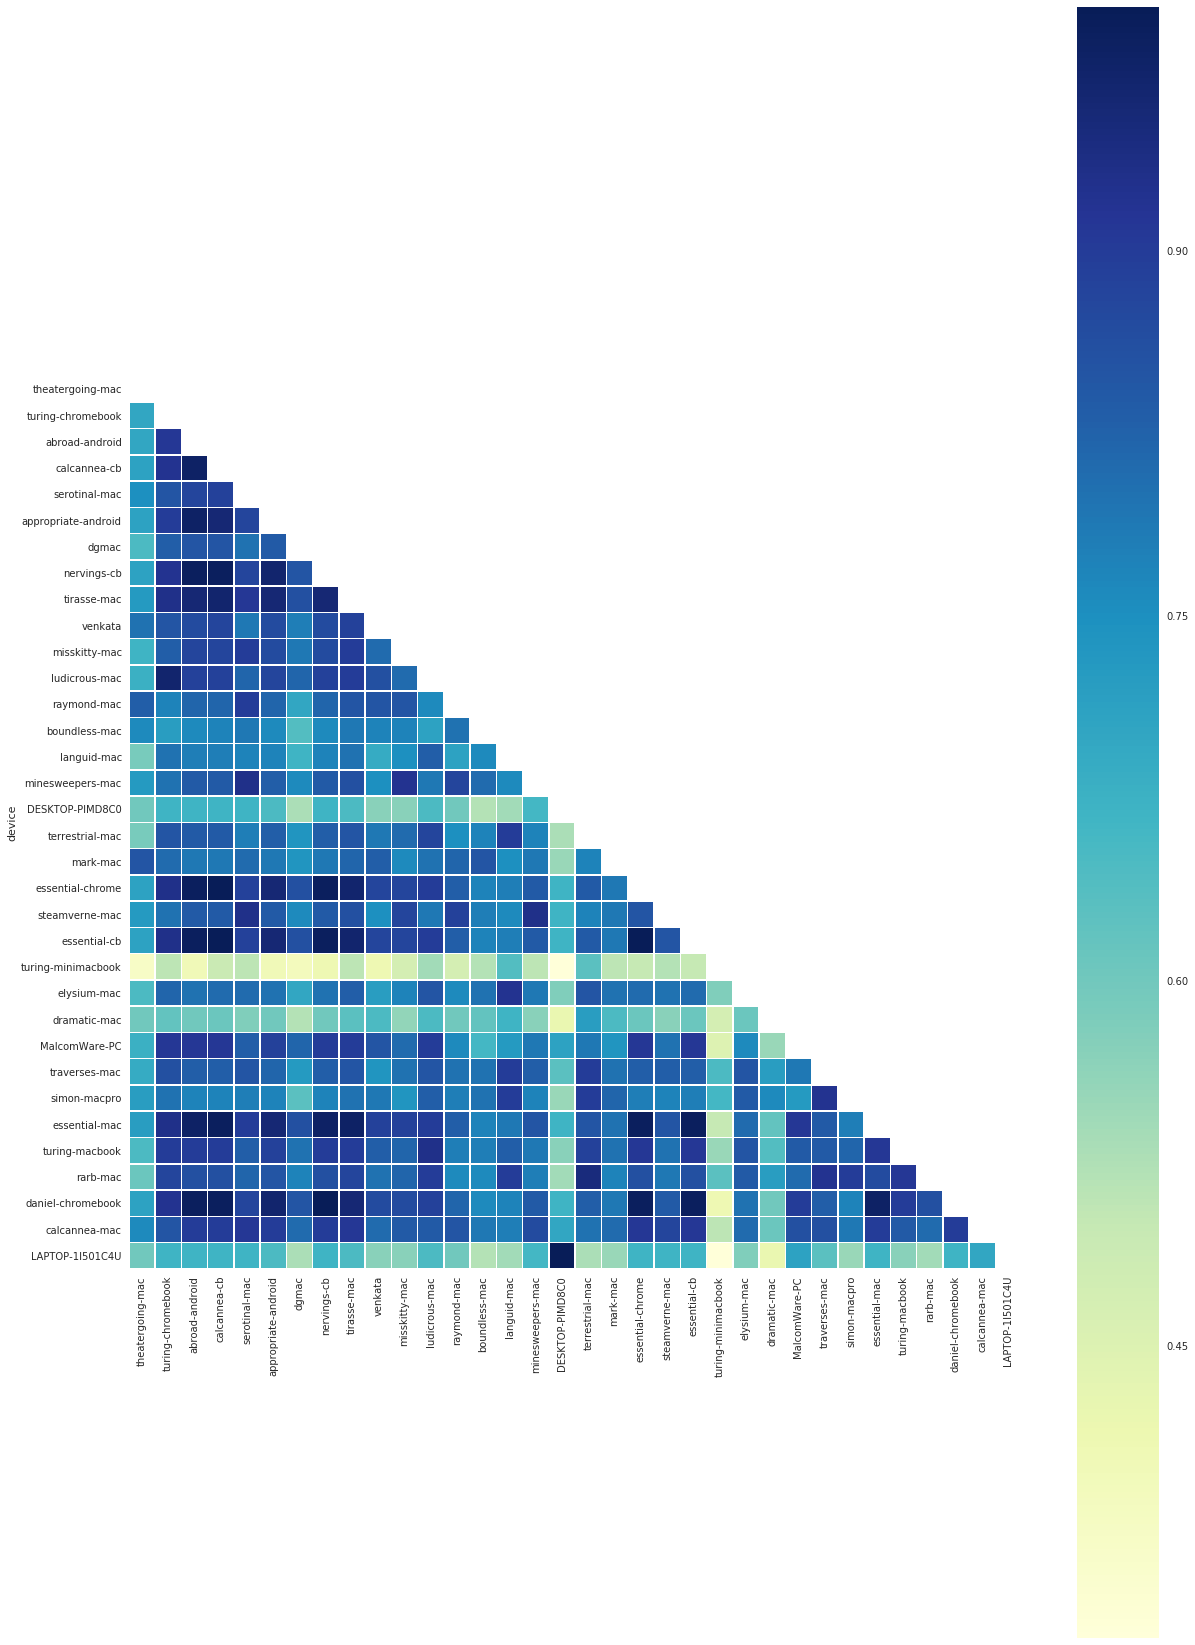

In [26]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()